<a href="https://colab.research.google.com/github/SoulOfWindTGN/CS112.L22/blob/main/notebooks/ColorHistogram_HOG_LBP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 5.6 MB/s 


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
import mahotas
import joblib
from skimage.feature import hog
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# đường dẫn đến tập training và testing data
train_path = "/content/drive/MyDrive/PatternRecognition/PlantsClassification/Data/bali-26_train"
test_path = "/content/drive/MyDrive/PatternRecognition/PlantsClassification/Data/bali-26_test"

In [ ]:
# số lượng các loài thực vật trong tập train
plant_types = os.listdir(train_path)
number_of_images = [] 
for plant in plant_types:
  num = len(os.listdir(os.path.join(train_path, plant)))
  number_of_images.append(num)

data = pd.DataFrame({'Name': plant_types, 'Number': number_of_images})
data

,Name,Number
0,bamboo,1925
1,banana,1716
2,cacao,1682
3,cinnamon,1224
4,coffeearabica,1341
5,dragonfruit,2109
6,durian,2437
7,frangipani,1567
8,guava,1931
9,jackfruit,2670


In [ ]:
# Đặc trưng 1: Color Histogram
bins = 8
def color_histogram(image, mask=None):
    # chuyển về không gian màu HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # tính histogram và chuẩn hóa
    hsv_hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hsv_hist, hsv_hist)
    return hsv_hist.flatten()

In [ ]:
# Đặc trưng 2: Histogram of Oriented Gradients (HOG)
def HOG_feature(img):
  # center crop ảnh theo tỉ lệ 1:2 (w:h) và resize về kích thước 64 x 128
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  center = (img.shape[0] // 2, img.shape[1]//2)
  h, w = img.shape[0], img.shape[1]
  if (w > h//2):
    img = img[:, center[1] - h//4: center[1] + h//4]
  resized_img = cv2.resize(img, (64, 128))
  # rút trích HOG feature
  feature = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
  return feature

In [ ]:
# Đặc trưng 3: Local Binary Pattern (LBP)
def LBP_feature(img):
  # center crop ảnh và resize về kích thước 250 x 250
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  center = (img.shape[0] // 2, img.shape[1]//2)
  h, w = img.shape[0], img.shape[1]
  if (w > h):
    img = img[:, center[1] - h//2: center[1] + h//2]
  resized_img = cv2.resize(img, (250, 250))
  # rút trích LBP feature
  lbp = mahotas.features.lbp(resized_img, 25, 16)
  return lbp

In [ ]:
# Hàm trích xuất và gom 3 features trên lại với nhau
def extract_feature(plant_dir, image):
  img = cv2.imread(os.path.join(plant_dir, image))
  histogram = color_histogram(img)
  hog = HOG_feature(img)
  lbp = LBP_feature(img)
  feature = np.hstack([histogram, hog, lbp])
  return feature

In [ ]:
# Trích xuất đặc trưng cho toàn bộ tập ảnh train
X=[]
y=[]
for plant in plant_types:
  print('+', plant)
  plant_dir = os.path.join(train_path, plant)
  for image in sorted(os.listdir(plant_dir)):
    feature = extract_feature(plant_dir, image)
    X.append(feature)
    y.append(plant_types.index(plant))

+ bamboo
+ banana
+ cacao
+ cinnamon
+ coffeearabica
+ dragonfruit
+ durian
+ frangipani
+ guava
+ jackfruit
+ lychee
+ mango
+ mangosteen
+ nilam
+ papaya
+ passiflora
+ sawo
+ snakefruit
+ starfruit
+ sugarpalm
+ suweg
+ taro
+ vanilla
+ waterguava
+ whitepepper
+ zodia


## Sử dụng một phần tập train để thử nghiệm trước

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=0)

In [ ]:
# Logistic Regresion
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
clf = LogisticRegression(random_state=0, max_iter=10000000)
clf = Pipeline([('scaler', StandardScaler()), ('lr', clf)])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
joblib.dump(clf, 'LogisticRegression.pkl')
print("Logistic Regression model's accuracy:", accuracy_score(y_test, clf.predict(X_test)))

Logistic Regression model's accuracy: 0.8926940639269406


In [ ]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb =  GaussianNB()
gnb = Pipeline([('scaler', StandardScaler()), ('gnb', gnb)])

gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
joblib.dump(gnb, 'GaussianNB.pkl')
print("GaussianNB model's accuracy:", accuracy_score(y_test, gnb.predict(X_test)))

GaussianNB model's accuracy: 0.45517904349915883


In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc = Pipeline([('scaler', StandardScaler()), ('decisiontree', dtc)])

dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
joblib.dump(dtc, 'DecisionTreeClassifier.pkl')
accuracy_score(y_test, dtc.predict(X_test))
print("DecisionTreeClassifier'ss model accuracy:", accuracy_score(y_test, dtc.predict(X_test)))

DecisionTreeClassifier'ss model accuracy: 0.862853480733798


## Sử dụng toàn bộ tập train huấn luyện Machine learning models + đánh giá trên tập test

In [ ]:
# mapping các class
map_label = {
  0: "bamboo", 1: "banana", 2: "cacao", 3: "cinnamon", 4: "coffeearabica",
  5: "dragonfruit", 6: "durian", 7: "frangipani", 8: "guava", 9: "jackfruit", 
  10: "lychee", 11: "mango", 12: "mangosteen", 13: "nilam", 14: "papaya",
  15: "passiflora", 16: "sawo", 17: "snakefruit", 18: "starfruit", 19: "sugarpalm", 
  20: "suweg", 21: "taro", 22: "vanilla", 23: "waterguava", 24: "whitepepper", 25: "zodia"
}

In [ ]:
# Logistic Regresion
lr = LogisticRegression()
lr = Pipeline([('scaler', StandardScaler()), ('LogisticRegression', lr)])
lr.fit(X, y)
joblib.dump(lr, 'LogisticRegression.pkl')

Images = []
Label = []
lr_trained = joblib.load('LogisticRegression.pkl')
for x in sorted(os.listdir(test_path)):
  print(x)
  pred = lr_trained.predict (extract_feature(test_path, x).reshape (1, -1))
  label = map_label[pred[0]]
  Images.append(x)
  Label.append(label)
result = pd.DataFrame({'id': Images, 'category': Label})
result.to_csv('submit_LogisticRegression.csv',index=False)

1.jpg
10.jpg
100.jpg
1000.jpg
1001.jpg
1002.jpg
1003.jpg
1004.jpg
1005.jpg
1006.jpg
1007.jpg
1008.jpg
1009.jpg
101.jpg
1010.jpg
1011.jpg
1012.jpg
1013.jpg
1014.jpg
1015.jpg
1016.jpg
1017.jpg
1018.jpg
1019.jpg
102.jpg
1020.jpg
1021.jpg
1022.jpg
1023.jpg
1024.jpg
1025.jpg
1026.jpg
1027.jpg
1028.jpg
1029.jpg
103.jpg
1030.jpg
1031.jpg
1032.jpg
1033.jpg
1034.jpg
1035.jpg
1036.jpg
1037.jpg
1038.jpg
1039.jpg
104.jpg
1040.jpg
1041.jpg
1042.jpg
1043.jpg
1044.jpg
1045.jpg
1046.jpg
1047.jpg
1048.jpg
1049.jpg
105.jpg
1050.jpg
1051.jpg
1052.jpg
1053.jpg
1054.jpg
1055.jpg
1056.jpg
1057.jpg
1058.jpg
1059.jpg
106.jpg
1060.jpg
1061.jpg
1062.jpg
1063.jpg
1064.jpg
1065.jpg
1066.jpg
1067.jpg
1068.jpg
1069.jpg
107.jpg
1070.jpg
1071.jpg
1072.jpg
1073.jpg
1074.jpg
1075.jpg
1076.jpg
1077.jpg
1078.jpg
1079.jpg
108.jpg
1080.jpg
1081.jpg
1082.jpg
1083.jpg
1084.jpg
1085.jpg
1086.jpg
1087.jpg
1088.jpg
1089.jpg
109.jpg
1090.jpg
1091.jpg
1092.jpg
1093.jpg
1094.jpg
1095.jpg
1096.jpg
1097.jpg
1098.jpg
1099.jpg
11.jpg


In [ ]:
# Naive Bayes
gnb = GaussianNB()
gnb = Pipeline([('scaler', StandardScaler()), ('GaussianNB', gnb)])
gnb.fit(X, y)
joblib.dump(dtc, 'GaussianNB.pkl')
Images = []
Label = []
gnb_trained = joblib.load('GaussianNB.pkl')
for x in sorted(os.listdir(test_path)):
  pred = gnb_trained.predict(extract_feature(test_path, x).reshape (1, -1))
  label = map_label[pred[0]]
  Images.append(x)
  Label.append(label)
result = pd.DataFrame({'id': Images, 'category': Label})
result.to_csv('submit_GaussianNB.csv',index=False)

In [ ]:
# Decision Tree
dct = DecisionTreeClassifier()
dct = Pipeline([('scaler', StandardScaler()), ('DecisionTreeClassifier', dct)])
dct.fit(X, y)
joblib.dump(dtc, 'DecisionTreeClassifier.pkl')

Images = []
Label = []
dct_trained = joblib.load('DecisionTreeClassifier.pkl')
for x in sorted(os.listdir(test_path)):
  pred = dct_trained.predict(extract_feature(test_path, x).reshape (1, -1))
  label = map_label[pred[0]]
  Images.append(x)
  Label.append(label)
result = pd.DataFrame({'id': Images, 'category': Label})
result.to_csv('submit_DecisionTree.csv',index=False)

# Một số hình ảnh dự đoán trên tập test

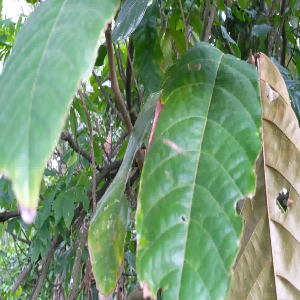

cacao
-----------------------------------------


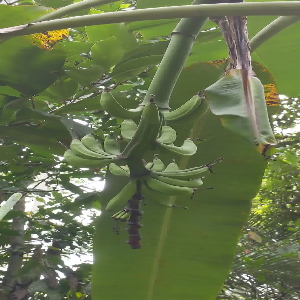

banana
-----------------------------------------


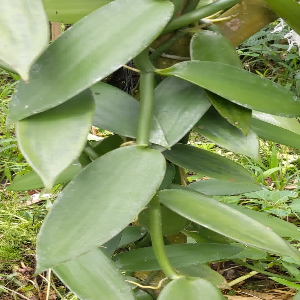

vanilla
-----------------------------------------


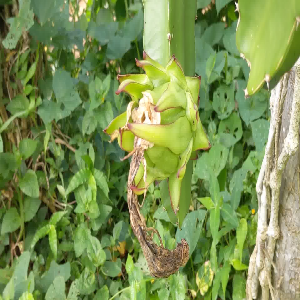

dragonfruit
-----------------------------------------


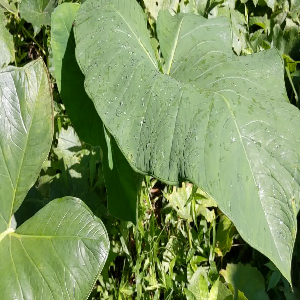

taro
-----------------------------------------


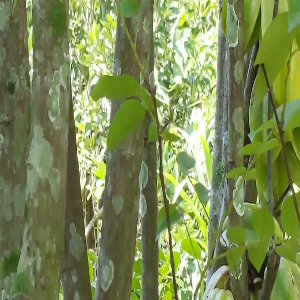

starfruit
-----------------------------------------


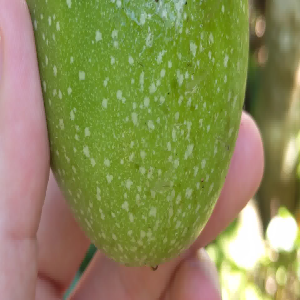

passiflora
-----------------------------------------


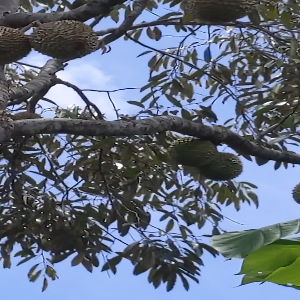

durian
-----------------------------------------


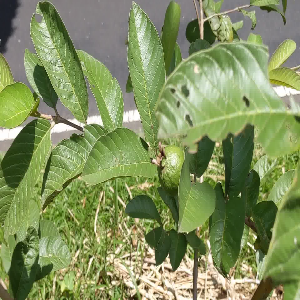

guava
-----------------------------------------


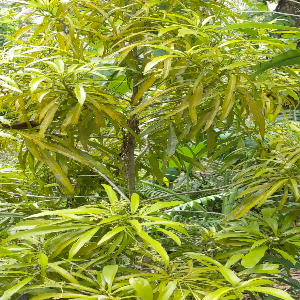

zodia
-----------------------------------------


In [ ]:
lr_trained = joblib.load('Logistic.pkl')
for x in os.listdir(test_path)[:10]:
  pred = lr_trained.predict(extract_feature(test_path, x).reshape(1, -1))
  label = map_label[pred[0]]
  img = cv2.imread(os.path.join(test_path, x))
  cv2_imshow(cv2.resize(img, (300, 300)))
  print(label)
  print("-----------------------------------------")